# Topographic SparseDream

## Intro

* **Date**: 12/13/2020
* **What**: This is the same architecture as the last experiment, but this time I'm adding local excitatory connections to promote topological organization of features.  Topological organization would be dope for a variety of reasons, but I think it will be key in higher level layers for isolating invariances in the data.  In this experiment, I'm going to use static lateral connections just to keep everything from going crazy, but if it works, I'll probably do variable connections next.
* **Why**: Because self-organization of features would be incredibly great.  Right now, the features have completely random placement.  By organization themselves topographically, (as I literally just mentioned) higher level layers I think should have an easier time sorting through different invariances in structure.  
* **Hopes**: In a perfect world, I would see a beautiful map of features in which local features are highly related.  
* **Limitations**: I suppose the only thing I'm worried about is whether the network will play nice with the static synapses.  I don't think there's any reason to think that the network won't simply correct itself if it perpetually fails, but I guess you never know.  Many of the things I create are very good at breaking themselves.

## Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10
from tqdm import tqdm
from scipy.special import expit as sig

(tr_x, _), (te_x, _) = cifar10.load_data()

In [2]:
s_len = 10
slh = s_len // 2
sl2 = s_len * s_len

data = tr_x[:, 16 - slh: 16 + slh, 16 - slh: 16 + slh]
flat_data = data.reshape(-1, sl2 * 3) / 255.0
fd_len = flat_data.shape[0]

te_data = te_x[:, 16 - slh: 16 + slh, 16 - slh: 16 + slh]
te_flat_data = te_data.reshape(-1, sl2 * 3) / 255.0

In [3]:
def draw_color_weights(w, Kx, Ky, fig, s_len):
    tapestry = np.zeros((s_len * Kx, s_len * Ky, 3))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len, 3)
            w_i += 1
            
    plt.clf()        
    im = plt.imshow(tapestry)
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


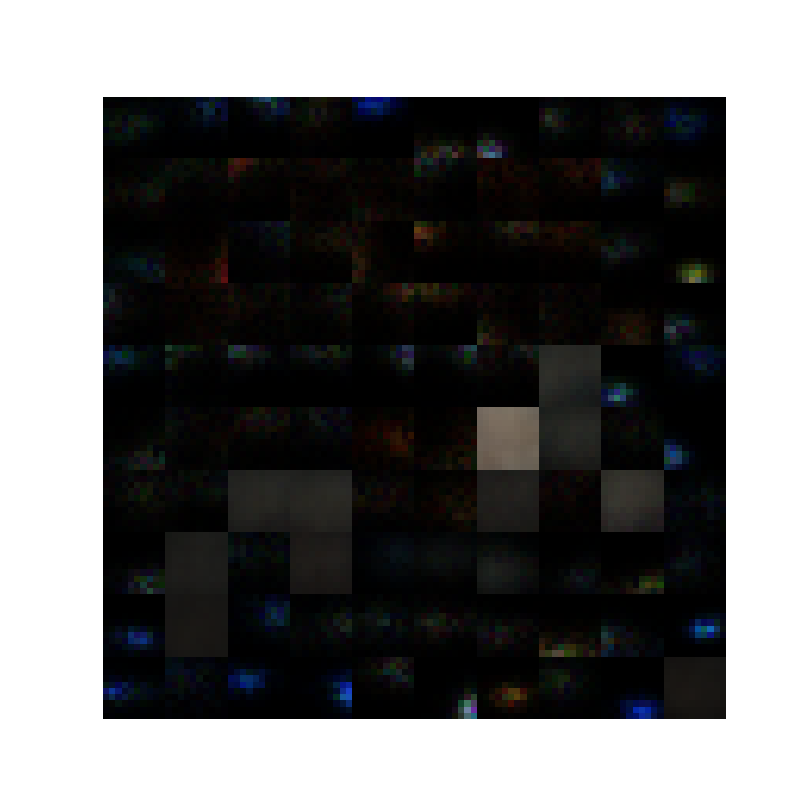

100%|█████████████████████████████████████████████████████████| 50000/50000 [00:18<00:00, 2670.32it/s]


In [27]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 1
T_s = 50000
Kx = 10
Ky = 10
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 1 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, sl2 * 3))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = flat_data[np.random.permutation(fd_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_color_weights(w, Kx, Ky, fig, s_len)

## Analysis Dialog

Alright, alright, alright!!  That's what I'm talking about!  Only having been trained on one epoch, you can start to see some degree of organization in the 100 neuron network.  Sick!  

Well fam, we both know I'm itching to do 900 neurons, but first, I think I'm going to do 400 neurons just cause it'll hopefully train more than twice as fast.  And, with 400 neurons I'll undoubtedly be able to see any structure that emerges.  

Ok, I'm going to do 10 epochs of 400 neurons, I'm going to do 1 nearest neighbor lateral excitation (so each neuron is getting feedback from 8 other neurons), and I'm setting the sparsity so about 20 neurons should be firing at once.

<IPython.core.display.Javascript object>


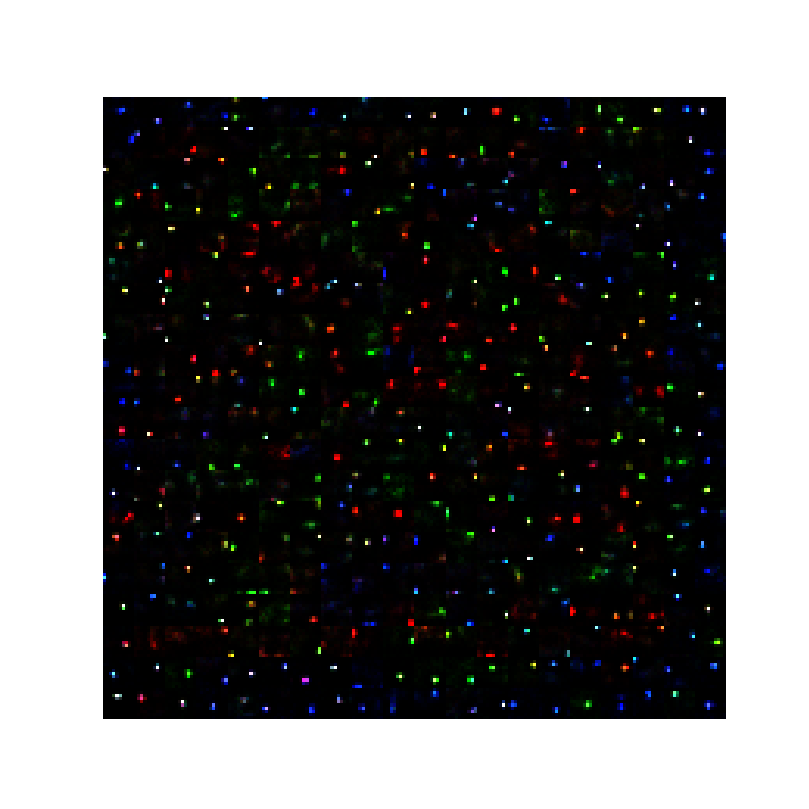

100%|█████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1672.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1680.35it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1678.38it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1551.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:32<00:00, 1523.00it/s]
Clipping input data to the valid range for im

In [32]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 50000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 1 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, sl2 * 3))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = flat_data[np.random.permutation(fd_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_color_weights(w, Kx, Ky, fig, s_len)

Well, this is interesting.  I think the main place where you could see any level of organization is the bottom row, which is predominantly blue.  That's kinda interesting that that happens.  I can maybe see some level of organization, but I think it might be my brain just seeing things that might not actually be there.  I think there might be some connections in the high and low frequency filters, in that it kinda looks like low freq filters are clusters together, but I don't know.  

To maybe try to promote more connections, I'm going to raise `ex` to 2 now, and try again.

<IPython.core.display.Javascript object>


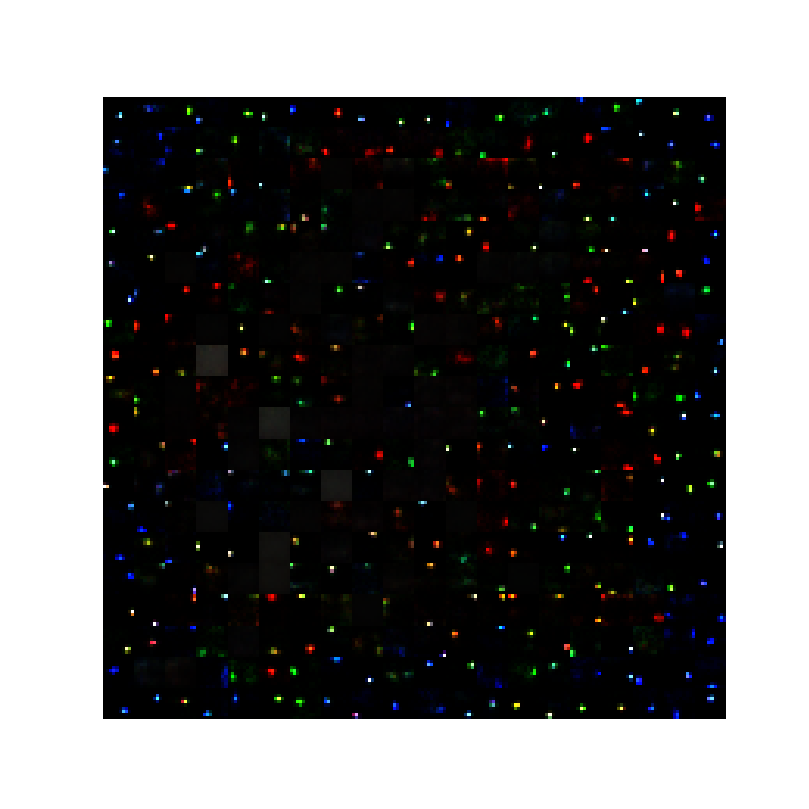

100%|█████████████████████████████████████████████████████████| 50000/50000 [00:29<00:00, 1706.70it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1598.43it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:30<00:00, 1655.97it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1607.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|█████████████████████████████████████████████████████████| 50000/50000 [00:30<00:00, 1636.46it/s]
Clipping input data to the valid range for im

In [33]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 50000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, sl2 * 3))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = flat_data[np.random.permutation(fd_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_color_weights(w, Kx, Ky, fig, s_len)

Hmm, so in comparing this with the features from the last experiment in which there were no topological connections, you can somewhat easily see that the blue is clustered near the corners, the red is prominent in the center, and the green is just all over the place.  Interesting.  I have an idea about how we can potentially see how the features are connected.  I'm going to do reconstructions, but I'm also going to plot a heatmap of the features for each image.  Hopefully we should see some level of clustering in the heatmap.

<IPython.core.display.Javascript object>


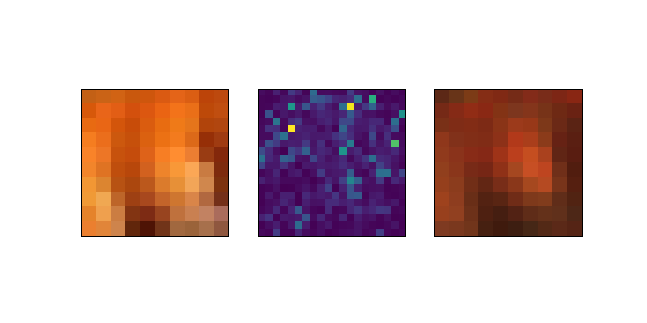

In [38]:
img_i = 110

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


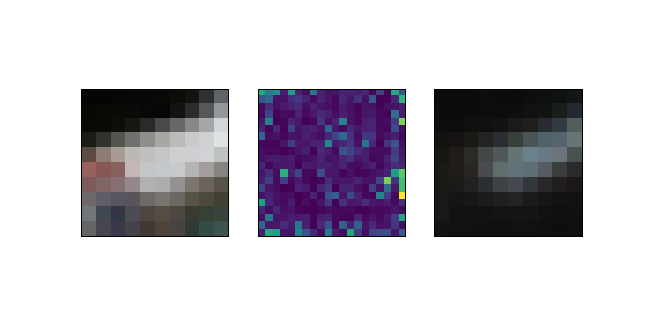

In [45]:
img_i = 401

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


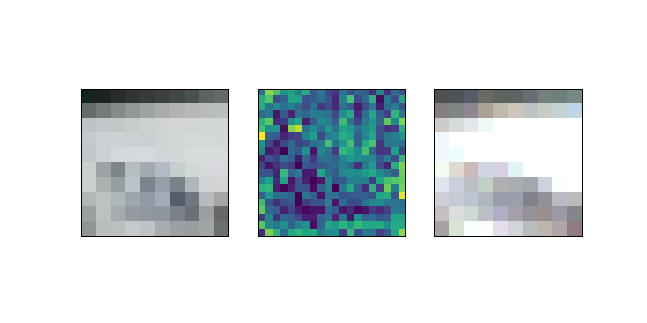

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [59]:
img_i = 656

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


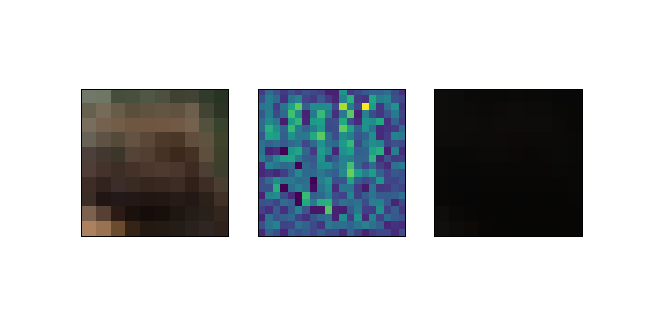

In [65]:
img_i = 420

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

Ok, so it looks like there's some clustering going on, perhaps.  The interesting thing is that we're getting quite a few images like the one above.  That's obviously not great.  However, this is interesting because I think what might be happening is that a bunch of neurons fire together for particular inputs, but they don't fire for other inputs.  So they are still sparse, but perhaps not sparse in the way we'd want, wherein different neurons fire for different inputs.  

That actually is a really compelling reason for inhibition.  Long-range lateral inhibition would hopefully prevent a bunch of neurons from firing at the same time, which would be super dope. 

Also, if the lateral synapses were plastic, we might not get the "every neuron fires together" effect as much because neurons would have weaken connections with neurons that are further away.

Ok, I'm going to do 900 neurons, and see what we can see.

I'm going do 2 nearest neighbor lateral excitation, and set the sparsity so that about 45 neurons fire at once.  10 epochs, baby.

<IPython.core.display.Javascript object>


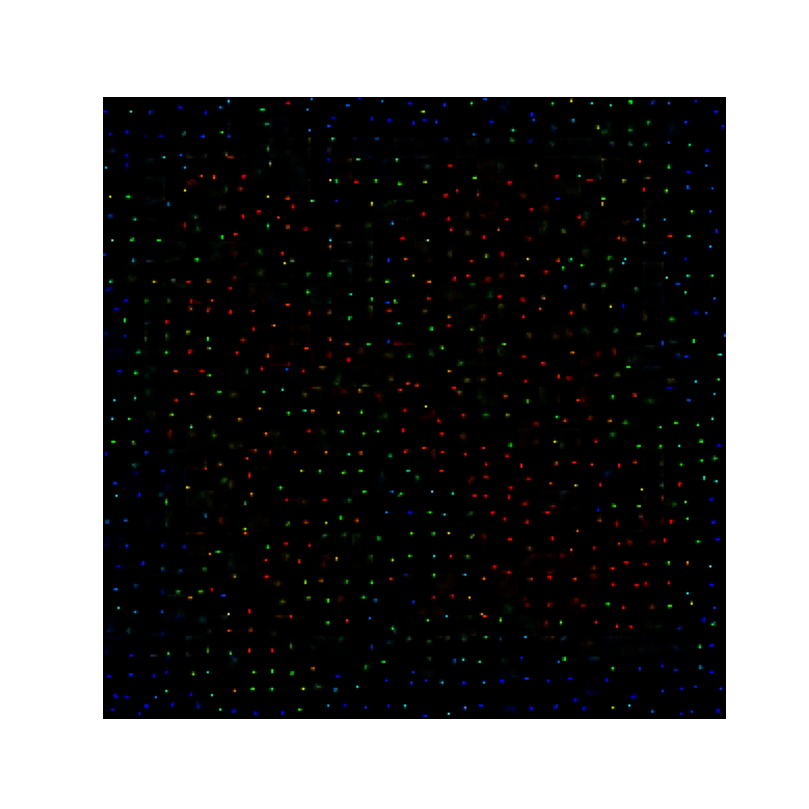

100%|██████████████████████████████████████████████████████████| 50000/50000 [03:44<00:00, 222.57it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [03:42<00:00, 224.34it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [03:42<00:00, 224.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [04:01<00:00, 207.26it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [04:13<00:00, 196.91it/s]
Clipping input data to the valid range for im

In [66]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 50000
Kx = 30
Ky = 30
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, sl2 * 3))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = flat_data[np.random.permutation(fd_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_color_weights(w, Kx, Ky, fig, s_len)

That's incredibly sick.  The topological organization of that feature map is incredibly striking, especially if you compare it to the feature map from the last experiment.  Just to qualitatively describe what I'm seeing, the blue is clustered mostly at the edges and corners, with a small amount of green interspersed, and almost no red.  There's a large red cluster near the lower right corner of the feature map, which really is only red.  There isn't a super strong green cluster.  It mostly looks like green is located where blue and red aren't.  

Ok, I'm going to do the same sort of reconstructions I did before.

<IPython.core.display.Javascript object>


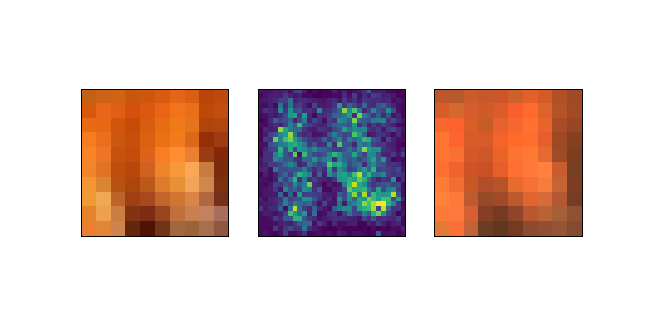

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [68]:
img_i = 110

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(30, 30))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


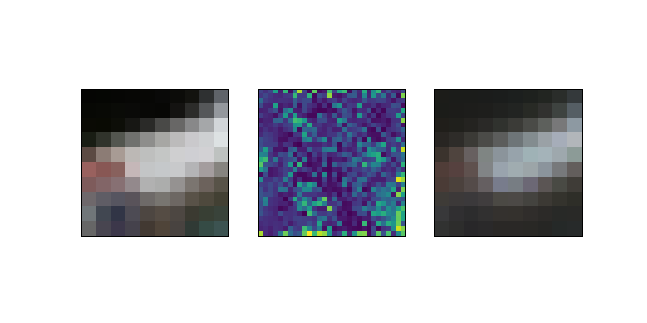

In [69]:
img_i = 401

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(30, 30))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


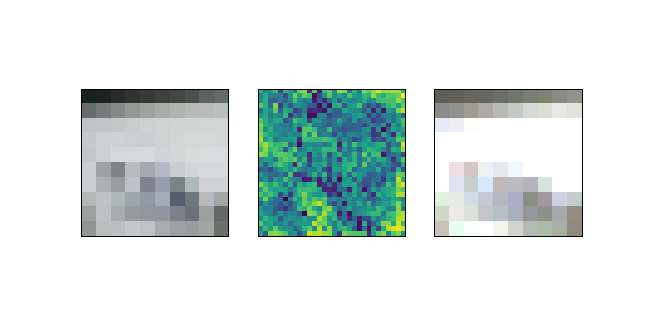

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [70]:
img_i = 656

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(30, 30))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


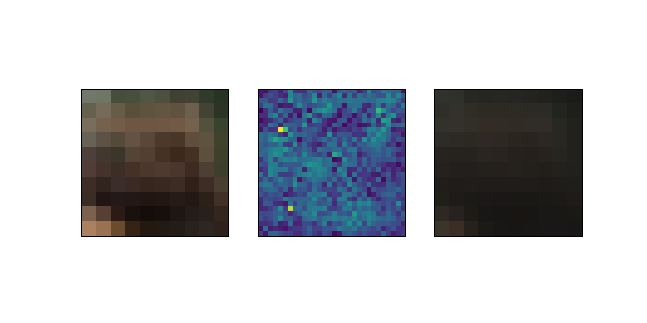

In [71]:
img_i = 420

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(30, 30))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


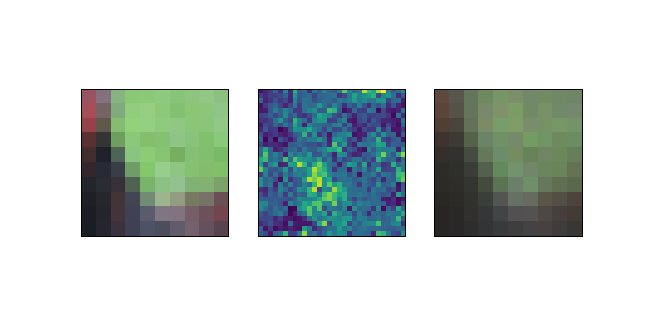

In [87]:
img_i = 25

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(30, 30))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

<IPython.core.display.Javascript object>


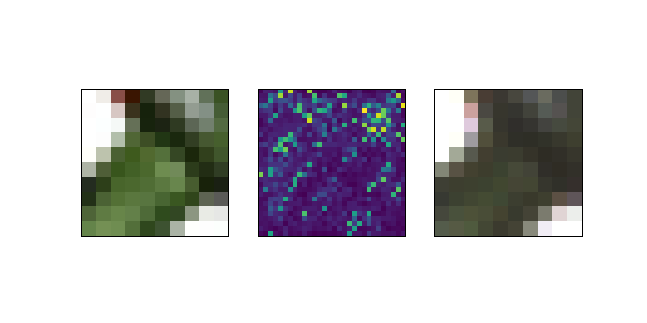

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [88]:
img_i = 98

img = te_flat_data[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len, 3))

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(30, 30))

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len, 3))

plt.show()

That last one is especially interesting.  Well, I mean, it looks like we're getting pretty obvious color-clustering in the feature heat-maps. I wonder about the extent to which we're getting clustering in other aspects of information.  Maybe that's why the blue always shows up first on the bottom.  

That actually is really interesting.  You know what I'm going to do?  I'm going to train that exact same model again, and I want to see the extent to which the structure of the feature map stays the same.  That would be incredibly interesting.  Let's see.  And if you're wondering if I'm getting bored while I wait 30 minutes for this to train, think again!  I'm watching the auditory coding lecture from VS265.

<IPython.core.display.Javascript object>


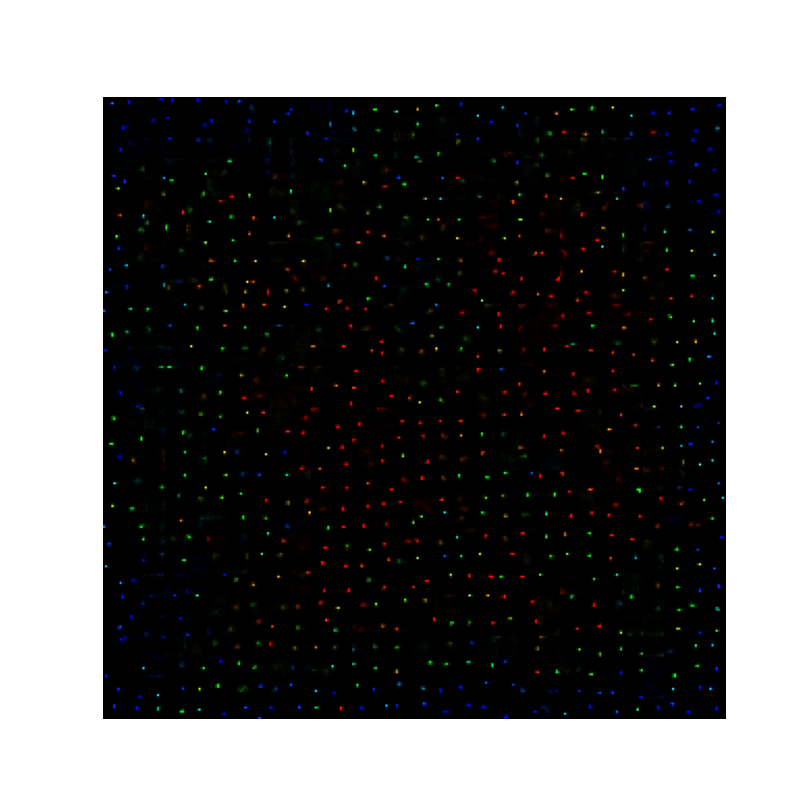

100%|██████████████████████████████████████████████████████████| 50000/50000 [04:15<00:00, 195.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [04:18<00:00, 193.67it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [03:45<00:00, 222.09it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [04:10<00:00, 199.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████████████████████████████████████████████████████| 50000/50000 [04:14<00:00, 196.33it/s]
Clipping input data to the valid range for im

In [89]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 50000
Kx = 30
Ky = 30
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, sl2 * 3))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = flat_data[np.random.permutation(fd_len)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_color_weights(w, Kx, Ky, fig, s_len)

Yeah, basically we have blue on the edges, red centralized, and green filling wherever else.  It's definitely not the same pattern as before.  Let there be no doubt about that.  

Ok, I'm not going to do reconstructions for these for obvious reasons (literally just did that), but before I wrap this experiment up, I'm going to do this analysis on mnist.  I'll be very interested in seeing the reconstruction heatmaps for mnist.  So I'll bring mnist in, and then I think I'll train a 400 neuron network on it.  It might take a pretty long time though.


In [2]:
from tensorflow.keras.datasets import mnist

(train_x, _), (test_x, _) = mnist.load_data()

m_flat_tr = train_x.reshape(train_x.shape[0], -1) / 255.0
m_flat_te = test_x.reshape(test_x.shape[0], -1) / 255.0 

m_tr_len, m_len = m_flat_tr.shape

In [3]:
def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Kx, s_len * Ky))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

<IPython.core.display.Javascript object>


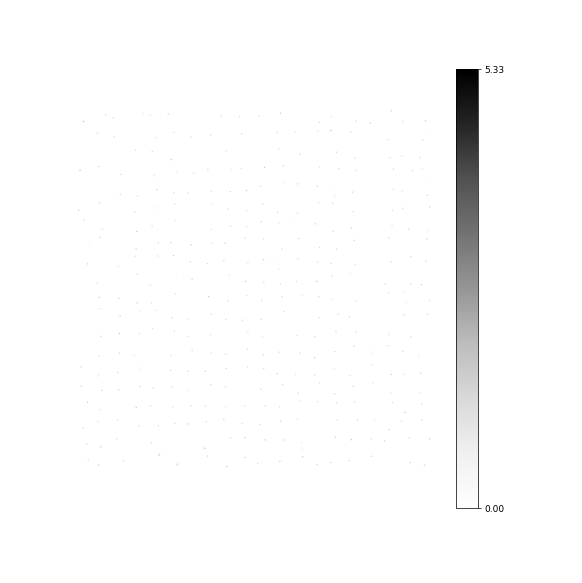

100%|██████████████████████████████████████████████████████████| 60000/60000 [04:55<00:00, 203.36it/s]


In [4]:
%matplotlib inline
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 60000
Kx = 20
Ky = 20
N = Kx * Ky
xi = 0.02
prec = 1e-10
ex = 2 # Nearest neighbor distance for lateral connections. So ex = 1 gives 8 neighbors, ex = 2 gives 24, etc

w = np.random.uniform(0.1, 1, (N, m_len))
t = np.zeros((N, 1))
sp = 0.05
gamma = 0.01

lat_ex = []

for y in range(Ky):
    for x in range(Kx):
        curr_ex = np.zeros((Ky, Kx))
        curr_ex[max(0, y - ex): min(Ky - 1, y + ex + 1), max(0, x - ex): min(Kx - 1, x + ex + 1)] = 1
        lat_ex.append(curr_ex.reshape(-1))
    
lat_ex = np.array(lat_ex)
np.fill_diagonal(lat_ex, 0)

for ep in range(Nep):
    inputs = m_flat_tr[np.random.permutation(60000)]
    for i in tqdm(range(T_s)):
        v = inputs[i].reshape(-1, 1)
        w_v = w @ v
        p = sig(w_v - t)
        o = sig(w_v + (lat_ex @ p) - t)
        r = w.T @ o
        mod_r = np.maximum(r, prec)
        e = v - r
        
        w += w * o * (e / mod_r).T * xi
        t += (o - sp) * gamma
        
        if i % 100 == 0:
            w = np.where(w > prec, w, 0)

    draw_weights(w, Kx, Ky, 28, fig)

Ok, I'm going to do some quick reconstructions before I eat lunch.

<IPython.core.display.Javascript object>


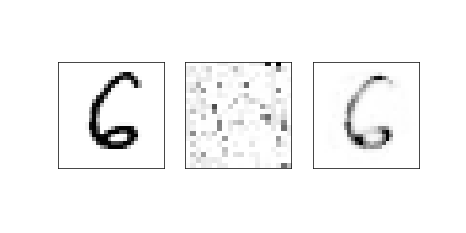

In [28]:
img_i = 98

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


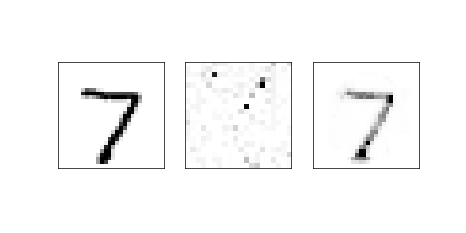

In [27]:
img_i = 0

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


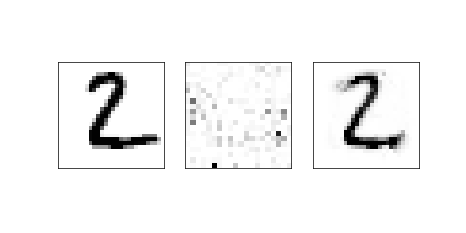

In [25]:
img_i = 1

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


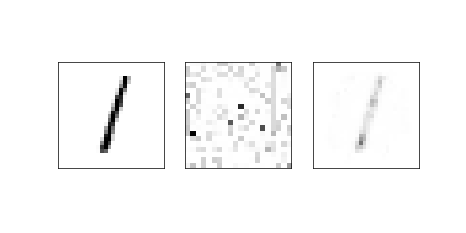

In [24]:
img_i = 2

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


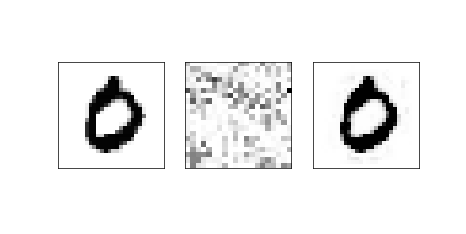

In [23]:
img_i = 3

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

<IPython.core.display.Javascript object>


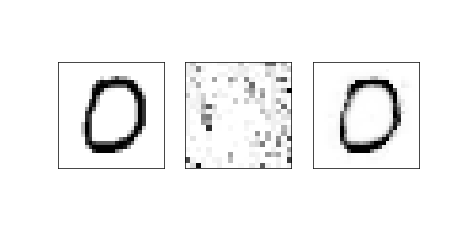

In [22]:
img_i = 10

s_len = 28

img = m_flat_te[img_i]

v = img.reshape(-1, 1)
w_v = w @ v
p = sig(w_v - t)
o = sig(w_v + (lat_ex @ p) - t)
r = w.T @ o

plt.figure(figsize=(8, 4))

plt.subplot(1, 3, 1)
plt.xticks([])
plt.yticks([])
plt.imshow(img.reshape(s_len, s_len), cmap="Greys")

plt.subplot(1, 3, 2)
plt.xticks([])
plt.yticks([])
plt.imshow(o.reshape(20, 20), cmap="Greys")

plt.subplot(1, 3, 3)
plt.xticks([])
plt.yticks([])
plt.imshow(r.reshape(s_len, s_len), cmap="Greys", vmax=1)

plt.show()

Wow, that's honestly not super compelling.  Basically, the network is doing pixel learning, which isn't super great.  It's super not doing any more major structural learning.  Perhaps I need to use a more brutal sparsity constant.  

Anyway, I think I'm going to wrap this experiment up, and move onto a new one.

## Conclusions

Well, this basic architecture for stimulating topographical connections in feature space did some really great things, especially with the color images.  If you take a gander at the 900 neuron networks, you can clearly see the clustering by colors, which hopefully means there's some notion of clustering in other types of components as well.  

In the next experiment, I'm going to mess around more with mnist, and see if I can build up more interesting feature topologies using different lateral excitation patterns.

## Next steps

Well, I kinda just said it, but I'm going to mess around with mnist next.  In future experiments, the same deal is afoot as last time.  Basically, I want variable strength lateral excitation, and I also need to figure out where inhibition and Hopfield networks fit into all of this.